# Import necessary libraries

### Data visualization

### No Contrails in this image

## Data visualization with Contrails

### In this image we can see contrails appear

## Load & Preprocess Dataset

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Enable mixed precision for 2-3x speedup
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Load patch IDs
patch_ids = os.listdir(train_path)
print(f"Found {len(patch_ids)} patches")

# SPEED OPTIMIZATION: Use only 25% of data for fast training
patch_ids = patch_ids[:len(patch_ids)//4]  # Use 5000 patches instead of 20000
print(f"Using {len(patch_ids)} patches for fast training")

2025-10-18 09:31:53.594790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760779913.811662      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760779913.876305      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20529 patches
Using 5132 patches for fast training


In [2]:
def compute_band_stats(patch_ids, train_path, sample_size=50):
    """Compute global band statistics from a small sample"""
    band_mins = [np.inf] * 16
    band_maxs = [-np.inf] * 16
    
    sample_ids = np.random.choice(patch_ids, min(sample_size, len(patch_ids)), replace=False)
    
    for pid in tqdm(sample_ids, desc="Computing band stats"):
        patch_folder = os.path.join(train_path, pid)
        
        for b in range(16):
            band_path = os.path.join(patch_folder, f"band_{b+1:02d}.npy")
            if os.path.exists(band_path):
                band_data = np.load(band_path)
                band_mins[b] = min(band_mins[b], band_data.min())
                band_maxs[b] = max(band_maxs[b], band_data.max())
    
    return band_mins, band_maxs

# Compute statistics quickly
band_mins, band_maxs = compute_band_stats(patch_ids, train_path, sample_size=50)
print("Band statistics computed!")

Computing band stats: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]

Band statistics computed!


In [3]:
import random
import tensorflow as tf

def fast_generator(patch_ids, train_path, band_mins, band_maxs, batch_size=16, include_negatives=True):
    """Optimized generator with negative samples"""
    while True:
        shuffled_ids = patch_ids.copy()
        np.random.shuffle(shuffled_ids)
        
        for i in range(0, len(shuffled_ids), batch_size):
            batch_ids = shuffled_ids[i:i + batch_size]
            X_batch, y_batch = [], []
            
            for pid in batch_ids:
                patch_folder = os.path.join(train_path, pid)
                
                # Load bands
                bands = []
                for b in range(1, 17):
                    band_path = os.path.join(patch_folder, f"band_{b:02d}.npy")
                    if os.path.exists(band_path):
                        band_data = np.load(band_path)
                        # Normalize
                        band_norm = (band_data - band_mins[b-1]) / (band_maxs[b-1] - band_mins[b-1] + 1e-6)
                        bands.append(band_norm)
                
                if len(bands) != 16:
                    continue
                
                image = np.stack(bands, axis=-1)
                
                # Load mask
                mask_file = os.path.join(patch_folder, "human_pixel_masks.npy")
                if os.path.exists(mask_file):
                    mask = np.load(mask_file)
                    mask = np.expand_dims(mask, axis=-1)
                    
                    # Include positives and some negatives
                    if mask.sum() > 0 or (include_negatives and random.random() < 0.25):
                        # Apply augmentation
                        if random.random() > 0.5:
                            image = np.fliplr(image)
                            mask = np.fliplr(mask)
                        if random.random() > 0.5:
                            image = np.flipud(image)
                            mask = np.flipud(mask)
                        
                        X_batch.append(image)
                        y_batch.append(mask)
                
                if len(X_batch) >= batch_size:
                    break
            
            if len(X_batch) > 0:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

# Split data
train_ids, val_ids = train_test_split(patch_ids, test_size=0.2, random_state=42)

print(f"Train patches: {len(train_ids)}")
print(f"Validation patches: {len(val_ids)}")

# Calculate steps (reduced for speed)
train_steps = len(train_ids) // 16  # Batch size 16
val_steps = len(val_ids) // 16

# Cap steps for faster epochs
train_steps = min(train_steps, 300)  # Max 300 steps per epoch
val_steps = min(val_steps, 50)       # Max 50 validation steps

print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

Train patches: 4105
Validation patches: 1027
Train steps per epoch: 256
Validation steps per epoch: 50


## Split into train & test

## Build U-Net Model

In [16]:
!ls -la /kaggle/input/google-research-identify-contrails-reduce-global-warming

total 17068
drwxr-xr-x     5 nobody nogroup        0 Oct 17 12:12 .
drwxr-xr-x     3 root   root        4096 Oct 18 09:31 ..
-rw-r--r--     1 nobody nogroup       76 Oct 17 11:43 sample_submission.csv
drwxr-xr-x     4 nobody nogroup        0 Oct 17 11:43 test
drwxr-xr-x 20531 nobody nogroup        0 Oct 17 12:10 train
-rw-r--r--     1 nobody nogroup 16018622 Oct 17 12:10 train_metadata.json
drwxr-xr-x  1858 nobody nogroup        0 Oct 17 12:12 validation
-rw-r--r--     1 nobody nogroup  1448528 Oct 17 12:12 validation_metadata.json


In [19]:
import json

with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    meta = json.load(f)

print(type(meta))
print(len(meta))
print(meta[0])  # show one entry


<class 'list'>
20529
{'record_id': '3283699311323360356', 'projection_wkt': 'PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]', 'row_min': 1686563.5, 'row_size': -1960.975830078125, 'col_min': 371650.9375, 'col_size': 1947.1307373046875, 'timestamp': 1571008800.0}


2025-10-18 13:42:49.297358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760794969.598212      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760794969.673556      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Loading metadata...
Training samples: 20529
Creating improved U-Net model...


2025-10-18 13:43:08.047713: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 8,120,997 (30.98 MB)

 Trainable params: 8,115,109 (30.96 MB)

 Non-trainable params: 5,888 (23.00 KB)

Loading training data with contrails...
Creating dataset with 2000 samples...


100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]


Successfully loaded 909/2000 samples with contrails

Analyzing class balance in training data:
Total pixels: 59572224
Contrail pixels: 682259 (1.1453%)
Background pixels: 58889965 (98.8547%)
Training data shape: (727, 256, 256, 3)
Validation data shape: (182, 256, 256, 3)
Class weights - Background: 0.51, Contrails: 43.70
Starting training with class imbalance handling...
46/46 ━━━━━━━━━━━━━━━━━━━━ 1285s 27s/step - accuracy: 0.7669 - iou: 0.0000e+00 - loss: 1.5346 - precision: 0.0264 - recall: 0.2278 - val_accuracy: 0.9840 - val_iou: 0.0000e+00 - val_loss: 1.5050 - val_precision: 0.0051 - val_recall: 0.0020 - learning_rate: 1.0000e-04


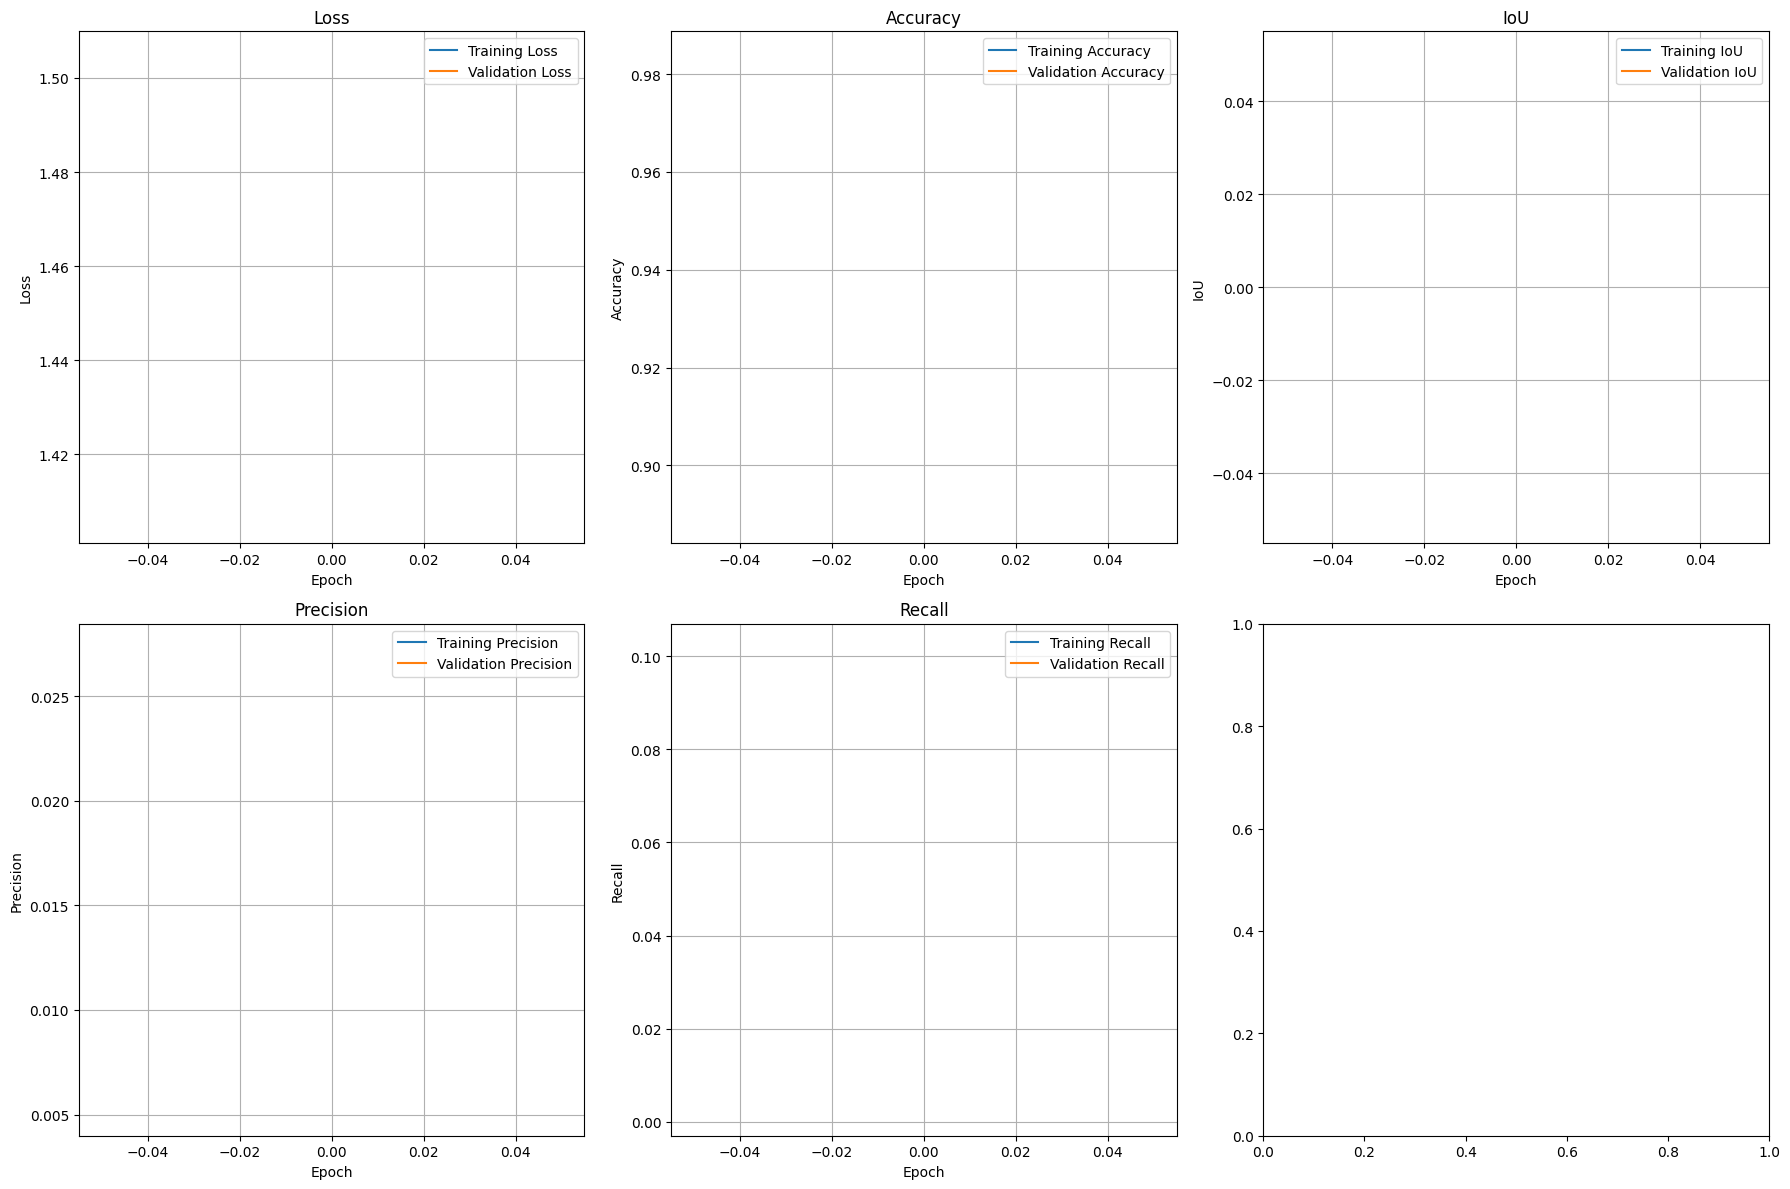

Visualizing predictions with analysis...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


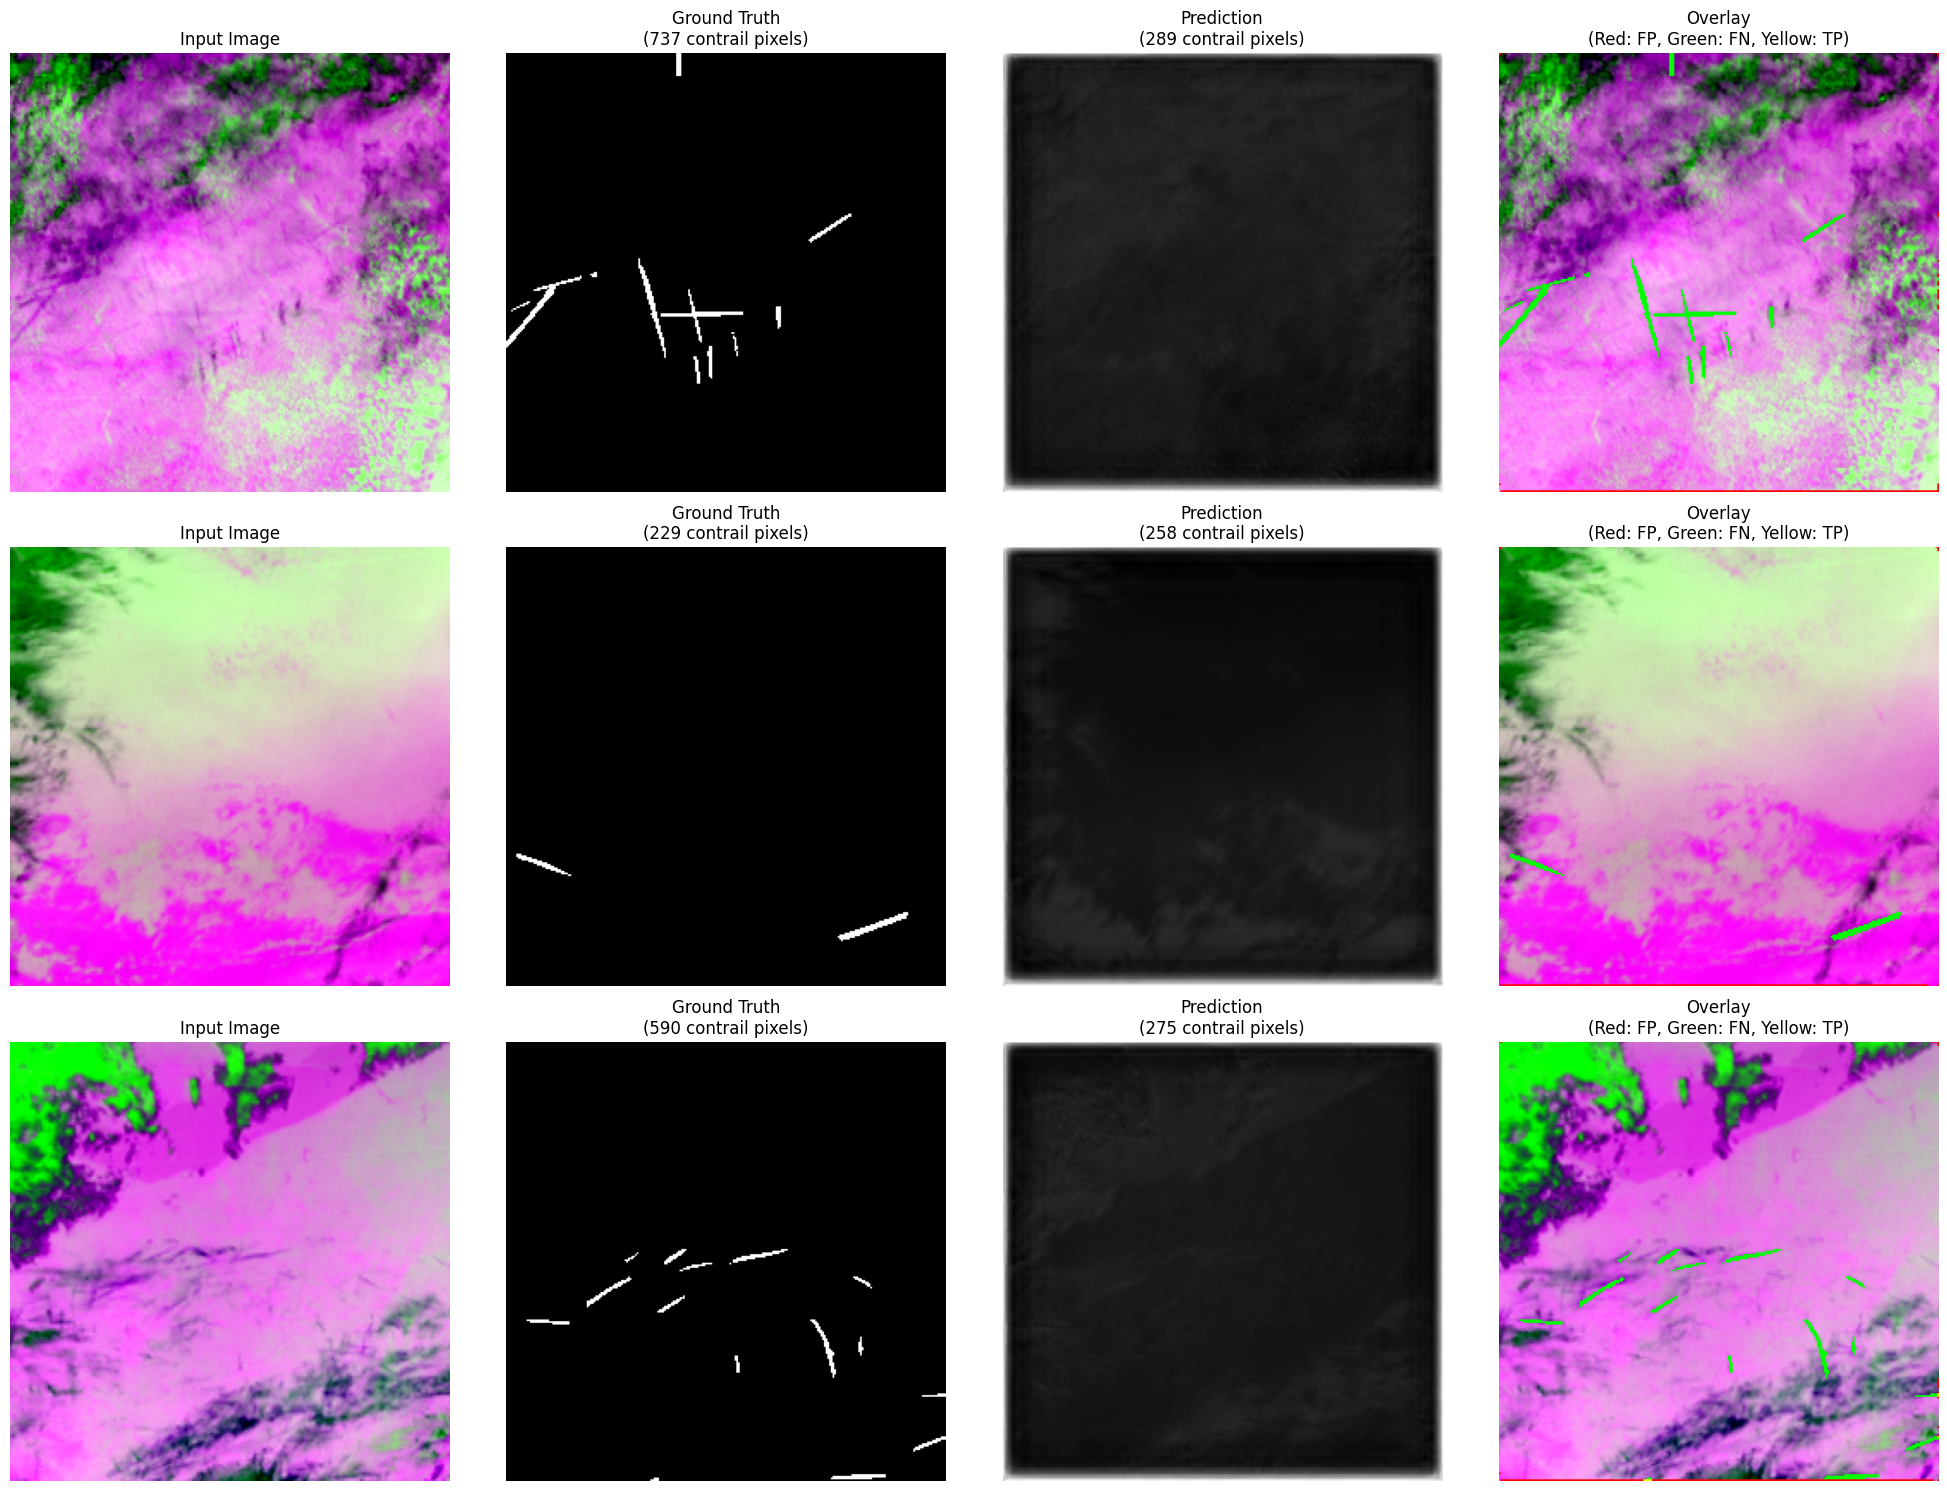

Sample 1 Metrics - Precision: 0.000, Recall: 0.000, IoU: 0.000
Model saved as 'contrail_detection_model_improved.h5'
Evaluating model...
Validation Metrics:
loss: 1.5050
compile_metrics: 0.9840
Code execution completed!


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Configuration
CONFIG = {
    'img_height': 256,
    'img_width': 256,
    'batch_size': 16,  # Reduced for memory
    'epochs': 1,
    'learning_rate': 1e-4,
    'random_seed': 42
}

# Set random seeds
tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Load metadata
print("Loading metadata...")
with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    train_meta = json.load(f)

print(f"Training samples: {len(train_meta)}")

# Define paths
BASE_PATH = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

def load_single_example(record_id, split='train'):
    """Load a single example including satellite data and human mask"""
    if split == 'train':
        data_path = TRAIN_PATH
    else:
        data_path = TRAIN_PATH  # Use train for validation split
    
    record_path = os.path.join(data_path, record_id)
    
    try:
        # Load band data
        band15 = np.load(os.path.join(record_path, "band_15.npy"))
        band14 = np.load(os.path.join(record_path, "band_14.npy"))
        band11 = np.load(os.path.join(record_path, "band_11.npy"))
        
        # Load human pixel masks
        human_pixel_masks = np.load(os.path.join(record_path, "human_pixel_masks.npy"))
        
        return {
            'band15': band15,
            'band14': band14, 
            'band11': band11,
            'human_pixel_masks': human_pixel_masks
        }
    except Exception as e:
        print(f"Error loading {record_id}: {e}")
        return None

def create_false_color_composite(band15, band14, band11):
    """Create better false color composite emphasizing contrails"""
    # Use temperature difference for better contrail detection
    temp_diff = band15 - band14  # Band 15 - Band 14 highlights contrails
    
    # Normalize with robust scaling
    r = (band15 - np.percentile(band15, 2)) / (np.percentile(band15, 98) - np.percentile(band15, 2))
    g = (temp_diff - np.percentile(temp_diff, 2)) / (np.percentile(temp_diff, 98) - np.percentile(temp_diff, 2))
    b = (band11 - np.percentile(band11, 2)) / (np.percentile(band11, 98) - np.percentile(band11, 2))
    
    # Clip to [0, 1]
    r = np.clip(r, 0, 1)
    g = np.clip(g, 0, 1)
    b = np.clip(b, 0, 1)
    
    false_color = np.stack([r, g, b], axis=-1)
    return false_color

def preprocess_data(band15, band14, band11, mask):
    """Preprocess satellite data and masks for model input"""
    # Create false color composite
    image = create_false_color_composite(band15, band14, band11)
    
    # Resize
    image = cv2.resize(image, (CONFIG['img_width'], CONFIG['img_height']))
    mask = cv2.resize(mask, (CONFIG['img_width'], CONFIG['img_height']))
    
    # Ensure mask is binary and proper shape
    mask = (mask > 0).astype(np.float32)
    
    return image, mask

def analyze_class_balance(masks):
    """Analyze class distribution in masks"""
    total_pixels = masks.size
    contrail_pixels = np.sum(masks > 0)
    background_pixels = total_pixels - contrail_pixels
    
    print(f"Total pixels: {total_pixels}")
    print(f"Contrail pixels: {contrail_pixels} ({contrail_pixels/total_pixels*100:.4f}%)")
    print(f"Background pixels: {background_pixels} ({background_pixels/total_pixels*100:.4f}%)")
    
    return contrail_pixels / total_pixels

def create_dataset(metadata, sample_size=None):
    """Create dataset from metadata"""
    if sample_size:
        metadata = metadata[:sample_size]
    
    images = []
    masks = []
    
    print(f"Creating dataset with {len(metadata)} samples...")
    
    successful_loads = 0
    for i, meta in enumerate(tqdm(metadata)):
        record_id = meta['record_id']
        
        data = load_single_example(record_id)
        if data is None:
            continue
            
        try:
            # Use the best timestep (you can improve this by finding the timestep with most contrails)
            band15 = data['band15'][:, :, 4]  # Middle timestep
            band14 = data['band14'][:, :, 4]
            band11 = data['band11'][:, :, 4]
            mask = data['human_pixel_masks']
            
            image, processed_mask = preprocess_data(band15, band14, band11, mask)
            
            # Only include samples that actually have contrails for initial training
            if np.sum(processed_mask) > 10:  # At least 10 contrail pixels
                images.append(image)
                masks.append(processed_mask)
                successful_loads += 1
            
        except Exception as e:
            continue
    
    print(f"Successfully loaded {successful_loads}/{len(metadata)} samples with contrails")
    return np.array(images), np.array(masks)

# Create improved U-Net model with attention
def unet_model_with_attention(input_shape=(256, 256, 3)):
    """Create U-Net model with attention for contrail segmentation"""
    
    def conv_block(x, filters, kernel_size=3, activation='relu'):
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x
    
    def attention_block(g, x, filters):
        """Attention gate"""
        g1 = layers.Conv2D(filters, 1, padding='same')(g)
        x1 = layers.Conv2D(filters, 1, padding='same')(x)
        psi = layers.Activation('relu')(layers.add([g1, x1]))
        psi = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(psi)
        return layers.multiply([x, psi])
    
    # Input
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    e1 = conv_block(inputs, 32)  # Reduced filters
    p1 = layers.MaxPooling2D((2, 2))(e1)
    
    e2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(e2)
    
    e3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(e3)
    
    e4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2, 2))(e4)
    
    # Bridge
    b = conv_block(p4, 512)
    
    # Decoder with attention
    u1 = layers.UpSampling2D((2, 2))(b)
    a1 = attention_block(u1, e4, 256)
    u1 = layers.concatenate([u1, a1])
    d1 = conv_block(u1, 256)
    
    u2 = layers.UpSampling2D((2, 2))(d1)
    a2 = attention_block(u2, e3, 128)
    u2 = layers.concatenate([u2, a2])
    d2 = conv_block(u2, 128)
    
    u3 = layers.UpSampling2D((2, 2))(d2)
    a3 = attention_block(u3, e2, 64)
    u3 = layers.concatenate([u3, a3])
    d3 = conv_block(u3, 64)
    
    u4 = layers.UpSampling2D((2, 2))(d3)
    a4 = attention_block(u4, e1, 32)
    u4 = layers.concatenate([u4, a4])
    d4 = conv_block(u4, 32)
    
    # Output with sigmoid activation
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d4)
    
    model = keras.Model(inputs, outputs)
    return model

# Create weighted loss function to handle class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * tf.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fn

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)

# Create and compile model
print("Creating improved U-Net model...")
model = unet_model_with_attention(input_shape=(CONFIG['img_height'], CONFIG['img_width'], 3))

# Use combined loss to handle class imbalance
model.compile(
    optimizer=keras.optimizers.Adam(CONFIG['learning_rate']),
    loss=combined_loss,
    metrics=['accuracy', 
             keras.metrics.IoU(num_classes=2, target_class_ids=[1], name='iou'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("Model summary:")
model.summary()

# Load data with contrails only for initial training
print("Loading training data with contrails...")
train_images, train_masks = create_dataset(train_meta[:2000])  # Use more samples

# Analyze class balance
print("\nAnalyzing class balance in training data:")
contrail_ratio = analyze_class_balance(train_masks)

# Split data
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=CONFIG['random_seed']
)

print(f"Training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")

# Add channel dimension to masks
train_masks = np.expand_dims(train_masks, axis=-1)
val_masks = np.expand_dims(val_masks, axis=-1)

# Create class weights for loss (handle imbalance)
def calculate_class_weights(masks):
    contrail_pixels = np.sum(masks > 0)
    total_pixels = masks.size
    background_pixels = total_pixels - contrail_pixels
    
    weight_contrail = total_pixels / (2 * contrail_pixels) if contrail_pixels > 0 else 1.0
    weight_background = total_pixels / (2 * background_pixels)
    
    return weight_background, weight_contrail

bg_weight, contrail_weight = calculate_class_weights(train_masks)
print(f"Class weights - Background: {bg_weight:.2f}, Contrails: {contrail_weight:.2f}")

# Create datasets with balancing
def create_balanced_dataset(images, masks, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    
    # Add augmentation
    augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])
    
    def augment_data(image, mask):
        # Apply same augmentation to both image and mask
        combined = tf.concat([image, mask], axis=-1)
        combined = augmentation(combined)
        image = combined[:, :, :3]
        mask = combined[:, :, 3:]
        return image, mask
    
    dataset = dataset.map(augment_data)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_balanced_dataset(train_images, train_masks, CONFIG['batch_size'])
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=8,
        restore_best_weights=True,
        monitor='val_iou',
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        patience=5,
        factor=0.5,
        min_lr=1e-7,
        monitor='val_loss'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_contrail_model.h5',
        save_best_only=True,
        monitor='val_iou',
        mode='max'
    )
]

# Train the model
print("Starting training with class imbalance handling...")
history = model.fit(
    train_dataset,
    epochs=CONFIG['epochs'],
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    metrics = ['loss', 'accuracy', 'iou', 'precision', 'recall']
    titles = ['Loss', 'Accuracy', 'IoU', 'Precision', 'Recall']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        row, col = i // 3, i % 3
        if metric in history.history:
            axes[row, col].plot(history.history[metric], label=f'Training {title}')
            if f'val_{metric}' in history.history:
                axes[row, col].plot(history.history[f'val_{metric}'], label=f'Validation {title}')
            axes[row, col].set_title(title)
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel(title)
            axes[row, col].legend()
            axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Visualize predictions with better analysis
def visualize_predictions_with_analysis(model, images, masks, num_samples=3):
    """Visualize predictions with detailed analysis"""
    if len(images) == 0:
        print("No images to visualize")
        return
        
    predictions = model.predict(images[:num_samples])
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        # Original image
        axes[i][0].imshow(images[i])
        axes[i][0].set_title('Input Image')
        axes[i][0].axis('off')
        
        # Ground truth mask
        gt_mask = masks[i].squeeze()
        axes[i][1].imshow(gt_mask, cmap='gray')
        contrail_pixels_gt = np.sum(gt_mask > 0)
        axes[i][1].set_title(f'Ground Truth\n({contrail_pixels_gt} contrail pixels)')
        axes[i][1].axis('off')
        
        # Prediction
        pred_mask = predictions[i].squeeze()
        axes[i][2].imshow(pred_mask, cmap='gray')
        contrail_pixels_pred = np.sum(pred_mask > 0.5)  # Threshold at 0.5
        axes[i][2].set_title(f'Prediction\n({contrail_pixels_pred} contrail pixels)')
        axes[i][2].axis('off')
        
        # Overlay
        overlay = images[i].copy()
        # Red for false positives, Green for true positives
        overlay[pred_mask > 0.5] = [1, 0, 0]  # Red for predictions
        overlay[gt_mask > 0] = [0, 1, 0]      # Green for ground truth
        # Yellow where both exist
        overlay[(pred_mask > 0.5) & (gt_mask > 0)] = [1, 1, 0]
        
        axes[i][3].imshow(overlay)
        axes[i][3].set_title('Overlay\n(Red: FP, Green: FN, Yellow: TP)')
        axes[i][3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics for first sample
    if num_samples > 0:
        gt_flat = masks[0].flatten()
        pred_flat = (predictions[0].flatten() > 0.5).astype(np.float32)
        
        tp = np.sum((gt_flat == 1) & (pred_flat == 1))
        fp = np.sum((gt_flat == 0) & (pred_flat == 1))
        fn = np.sum((gt_flat == 1) & (pred_flat == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        
        print(f"Sample 1 Metrics - Precision: {precision:.3f}, Recall: {recall:.3f}, IoU: {iou:.3f}")

print("Visualizing predictions with analysis...")
visualize_predictions_with_analysis(model, val_images, val_masks, num_samples=min(3, len(val_images)))

# Save the model
model.save('contrail_detection_model_improved.h5')
print("Model saved as 'contrail_detection_model_improved.h5'")

# Evaluate the model
print("Evaluating model...")
if len(val_dataset) > 0:
    results = model.evaluate(val_dataset, verbose=0)
    print("Validation Metrics:")
    for name, value in zip(model.metrics_names, results):
        print(f"{name}: {value:.4f}")

print("Code execution completed!")